In [1]:
# All imports
from glob import glob
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np

__DEBUG__= False

In [2]:
# Function for performing camera calibraation

def calibrate_camera(calib_img_dir,nb_x_corners,nb_y_corners):
    
    calib_img_paths = glob(calib_img_dir+'*.jpg')

    # Object points are 3-D integral coordinates of all internal corners
    # in a Chessboard image. The z coordinates are all zero.

    # The object points matrix has as many columns as there are x positions
    # and as many rows as there are y positions.

    x_coords,y_coords = np.meshgrid(range(nb_x_corners),range(nb_y_corners))
    z_coords = np.zeros(shape=[nb_y_corners,nb_x_corners])

    obj_points = np.dstack((x_coords,y_coords,z_coords))

    # Reshape the matrx of coordinates in to a list that has all coordinates
    # from left to right and top to bottom.
    obj_points = obj_points.reshape([-1,3])

    obj_points_list = []
    img_points_list = []

    detected = 0

    for path in tqdm(calib_img_paths):
        img = cv2.imread(path)
        grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grey,(nb_x_corners,nb_y_corners))

        if ret == True:
            if __DEBUG__:
                cv2.drawChessboardCorners(img,(nb_x_corners,nb_y_corners),corners,ret)
                plt.imshow(img)
                plt.show()

            obj_points_list.append(obj_points)
            img_points_list.append(corners)

            detected += 1
            
    # Reshape object points and image points as required by the new OpenCV interface
    obj_points_matrix = np.array(obj_points_list).reshape([detected,-1,3])
    img_points_matrix = np.array(img_points_list).reshape([detected,-1,2])
    
    # Perform actual calibration using our object points and 
    # image points found above.
    test_img = cv2.imread('camera_cal/calibration1.jpg')
    retval, cameraMatrix, distCoeffs, rvecs, tvecs =\
    cv2.calibrateCamera(obj_points_matrix.astype(np.float32),
                        img_points_matrix.astype(np.float32),
                        (test_img.shape[1],test_img.shape[0]),
                        None,
                        None)
    
    return retval, cameraMatrix, distCoeffs, rvecs, tvecs

In [3]:
# Camera calibration.

calib_img_dir = './camera_cal/'

# Number of internal corners in the calibration images.
# Obtained by manual inspection.
nb_x_corners = 9
nb_y_corners = 6

retval, cameraMatrix, distCoeffs, rvecs, tvecs = calibrate_camera(calib_img_dir,nb_x_corners,nb_y_corners)

100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


In [4]:
def plot_many(imgs,titles,shape,cmaps=None,figsize=(24,9)):
    
    assert len(imgs) == len(titles) and len(imgs) == shape[0]*shape[1]
    
    fig, axes = plt.subplots(shape[0],shape[1],figsize=figsize)
    axes = axes.flatten()
    
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i],cmap=cmaps[i] if cmaps is not None else None)
        axes[i].set_title(titles[i])

    plt.show()

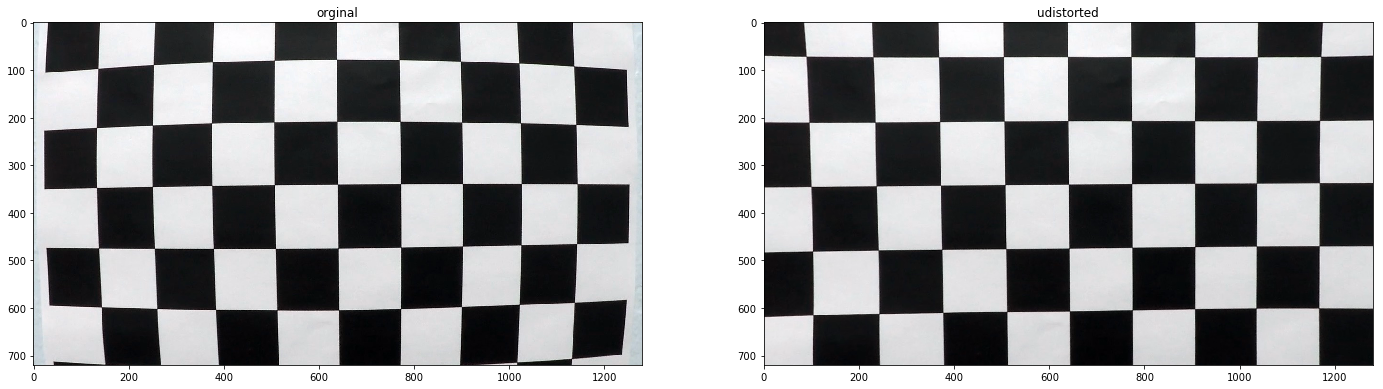

In [5]:
# Test distortion correction.
test_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(test_img,cameraMatrix,distCoeffs)

plot_many([test_img,undistorted],['orginal','udistorted'],[1,2])


In [6]:
def get_abs_sobel_mask(img, orient='x', kernel=3, thresh=(0,255)):
    
    grey  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    elif orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    else:
        raise Exception("Invalid orientation {}".format(x))
     
    scaled_abs_sobel = (255. * abs_sobel / np.max(abs_sobel)).astype(np.uint8)
    
    binary_mask = np.logical_and(abs_sobel >= thresh[0], abs_sobel <= thresh[1] )
    
    return binary_mask.astype(np.uint8)

In [7]:
def get_mag_sobel_mask(img, kernel=3, mag_thresh=(0,255)):
    
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    abs_sobel_x = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    abs_soble_y = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    abs_sobel_mag = np.sqrt(abs_sobel_x**2+abs_soble_y**2)
    
    scaled_abs_sobel_mag = (abs_sobel_mag * 255.0 / np.max(abs_sobel_mag)).astype(np.uint8)
    
    binary_mask = np.logical_and(scaled_abs_sobel_mag >= mag_thresh[0], 
                                 scaled_abs_sobel_mag <= mag_thresh[1])
    
    return binary_mask.astype(np.uint8)

In [8]:
def get_ang_sobel_mask(img, kernel=3, ang_thresh=(0,np.pi/2.)):
    
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    abs_sobel_x = np.abs(cv2.Sobel(grey,cv2.CV_64F,1,0,None,kernel))
    abs_soble_y = np.abs(cv2.Sobel(grey,cv2.CV_64F,0,1,None,kernel))
    
    
    abs_sobel_angle = np.arctan2(abs_soble_y,abs_sobel_x)
    
    
    binary_mask = np.logical_and(abs_sobel_angle >= ang_thresh[0], 
                                 abs_sobel_angle <= ang_thresh[1])
    
    return binary_mask.astype(np.uint8)

In [9]:
# Combine masks
def combine_masks(mask_a,mask_b,comb_fn):
    return comb_fn(mask_a,mask_b).astype(np.uint8)

In [10]:
def get_all_sobel_masks(img):
    
    x_mask = get_abs_sobel_mask(img,orient='x',kernel=3,thresh=(50,180))
    y_mask = get_abs_sobel_mask(img,orient='y',kernel=3,thresh=(50,180))
    mag_mask = get_mag_sobel_mask(img,kernel=3,mag_thresh=(80,150))
    ang_mask = get_ang_sobel_mask(img,kernel=15,ang_thresh=(0.85,1.0))
    
    return [x_mask,y_mask,mag_mask,ang_mask]
    

In [11]:
def get_channel_mask_fn(chan_name:str):
    ''' 
    Returns a function that can be used to generate a binary mask from an BGR or HSV image.
    The function returned s configured based on the channel_name passed here.
    if the chan_name argument is 'h', 's' or 'v', automatic olorspace conversion would be done
    by the returned function.
    '''

    
    name_to_index = { 'b':0, 'g':1, 'r':2, 'h':0, 'l':1, 's':2}
    
    if chan_name not in name_to_index.keys():
        raise Exception('{} chan_name is not a valid chanel name'.format(chan_name))
        
    def no_conversion(img):
        return img
        
    color_scheme_converson_fn = lambda img: no_conversion(img) if chan_name in ['b','g','r'] else cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    
    def _f(img,thresh=(0,255)):
        '''
        img: BGR or HSV image.Performs automatic colorspace conversion if needed.
        '''
        img_converted = color_scheme_converson_fn(img)
        channel = img_converted[:,:,name_to_index[chan_name]]
        binary_mask = (np.logical_and(channel >= thresh[0], channel <= thresh[1])).astype(np.uint8)
    
        return binary_mask
    
    return _f

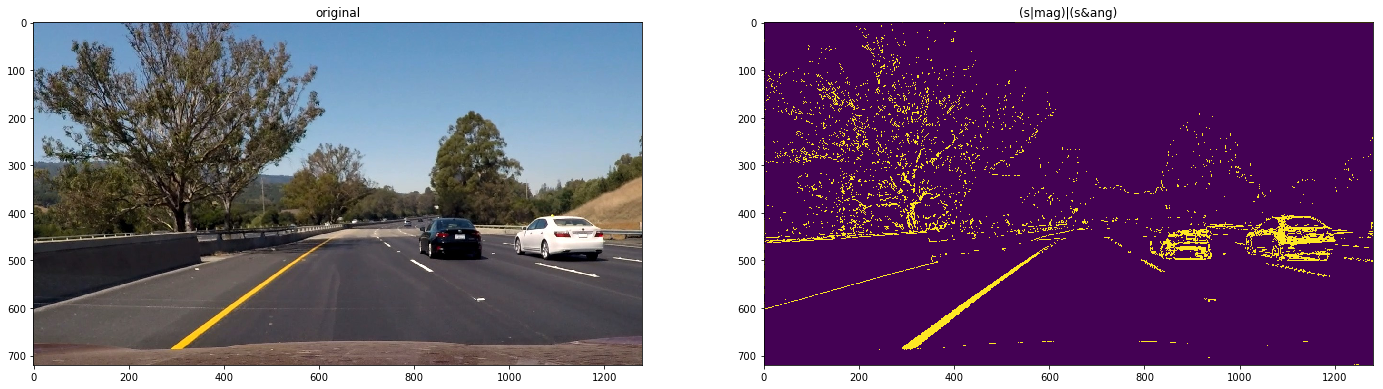

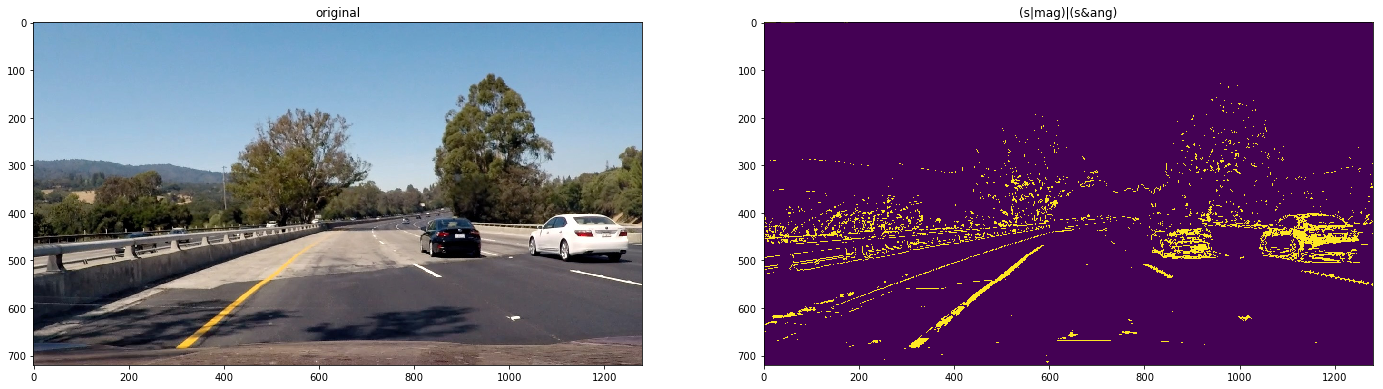

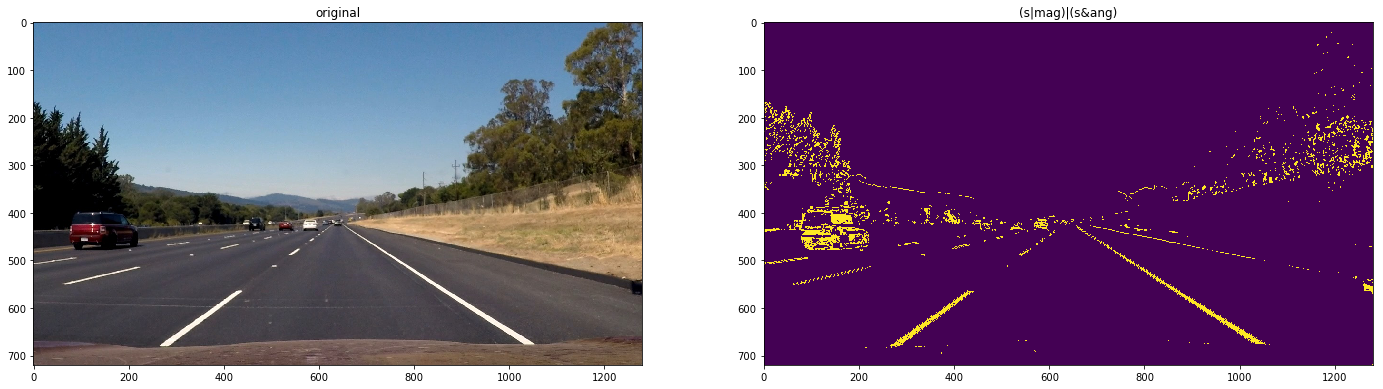

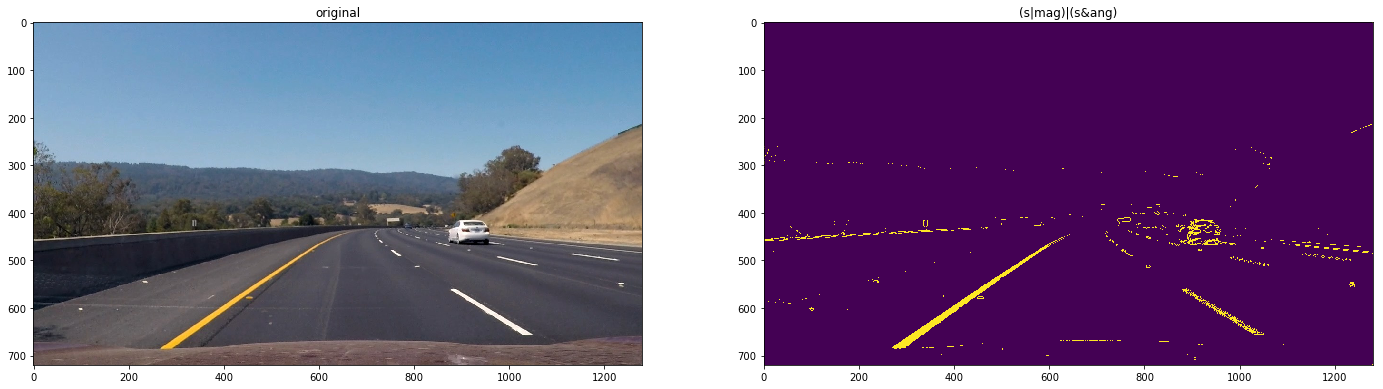

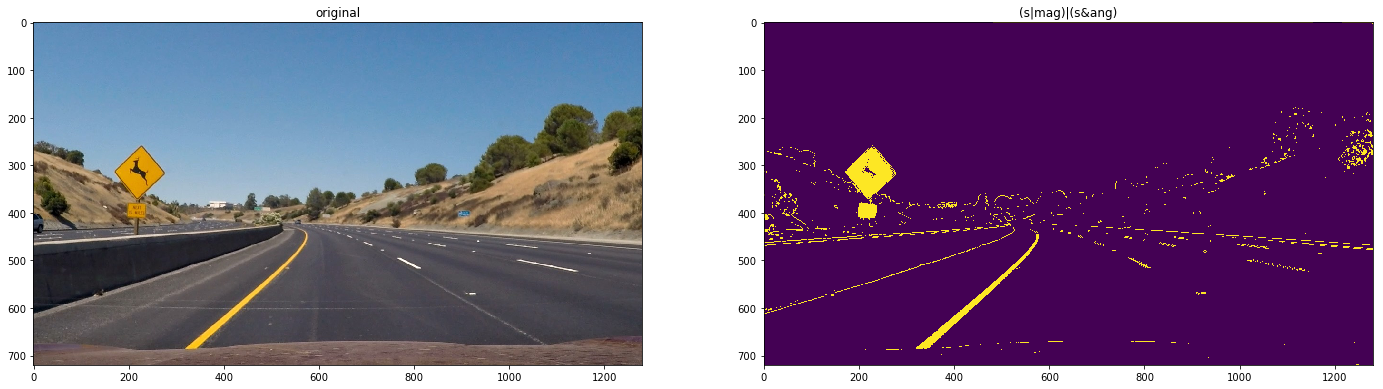

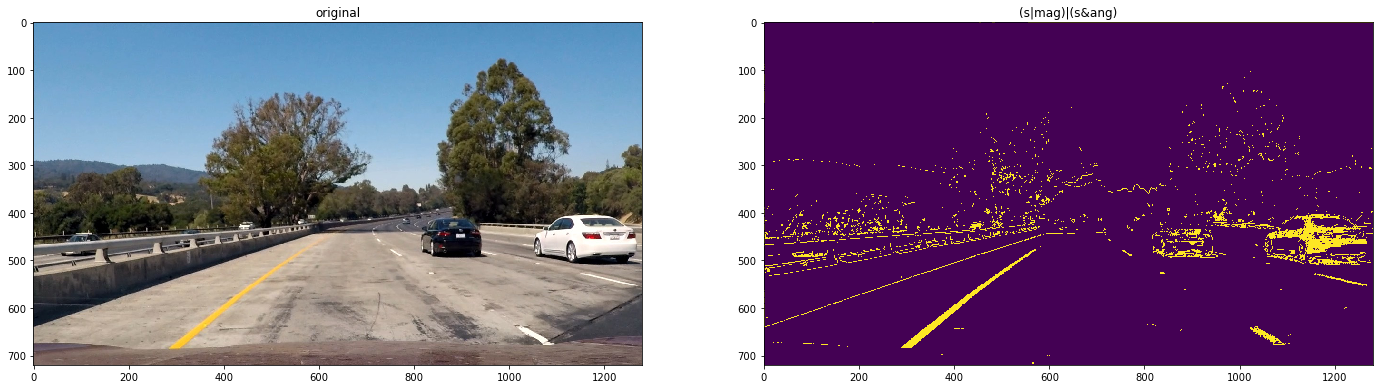

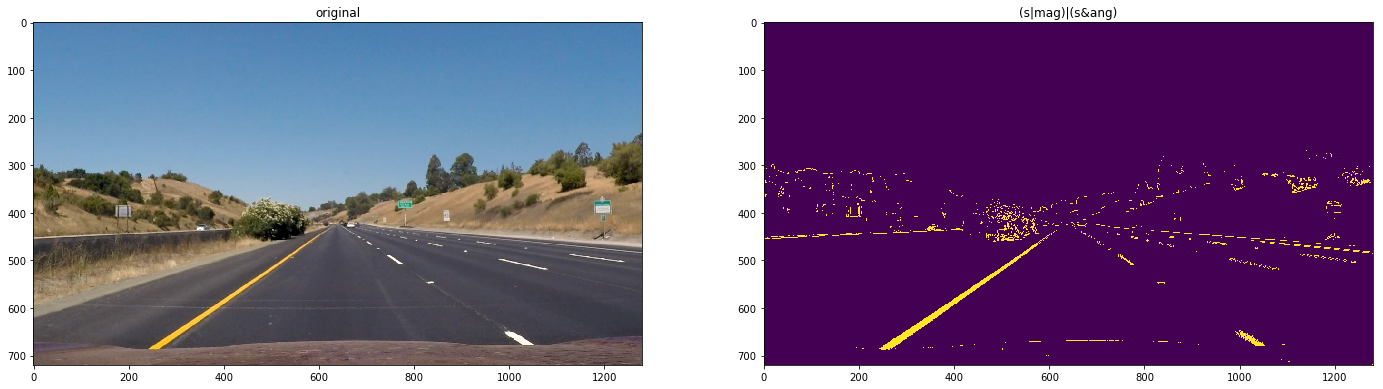

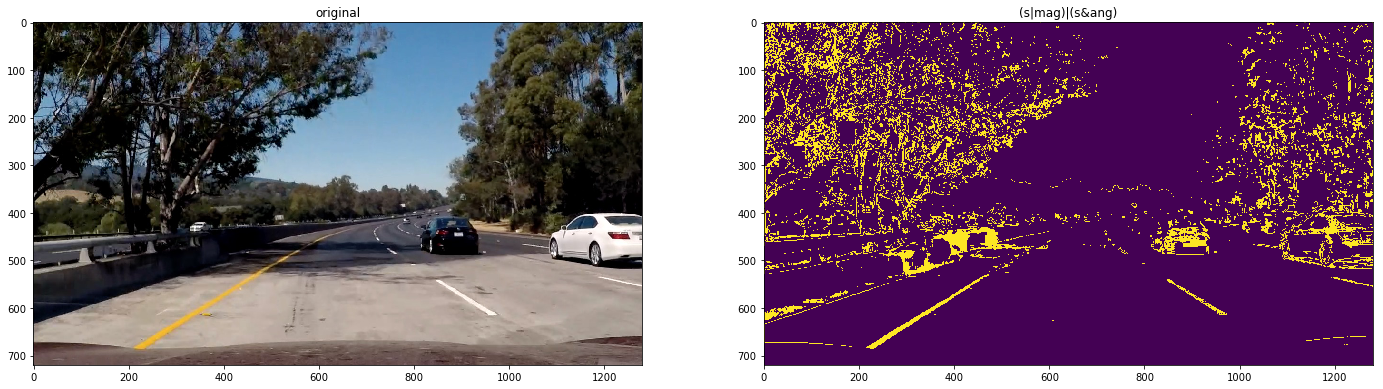

In [12]:
# Visulaize individual and combined sobel masks for all test images.
def visualize_mask_candidates(group=0):
    img_paths = glob('test_images/*.jpg')

    s_mask_fn = get_channel_mask_fn('s')
    h_mask_fn = get_channel_mask_fn('h')
    l_mask_fn = get_channel_mask_fn('l')

    for path in img_paths:
        img_bgr = cv2.imread(path)

        [x_mask,y_mask,mag_mask,ang_mask] = get_all_sobel_masks(img_bgr)
        x_y_mask = combine_masks(x_mask,y_mask,np.logical_and)
        mag_ang_mask = combine_masks(mag_mask,ang_mask,np.logical_and)

        all_mask1 = combine_masks(x_y_mask,mag_ang_mask,np.logical_or)

        s_mask = s_mask_fn(img_bgr,thresh=(170,255))

        x_s_mask = combine_masks(x_mask,s_mask,np.logical_or)
        y_s_mask = combine_masks(y_mask,s_mask,np.logical_and)
        x_y_s_mask = combine_masks(x_s_mask,y_s_mask,np.logical_and)

        mag_s_mask = combine_masks(mag_mask,s_mask,np.logical_or)
        ang_s_mask = combine_masks(ang_mask,s_mask,np.logical_and)
        mag_ang_s_mask = combine_masks(mag_s_mask,ang_s_mask,np.logical_or)

        all_mask2 = combine_masks(x_y_s_mask,mag_ang_s_mask,np.logical_or)

        rgb_img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    
        if group == 0:
            plot_many([rgb_img,x_mask,y_mask,x_y_mask,
                       mag_mask,ang_mask,mag_ang_mask,all_mask1,
                       s_mask,x_s_mask,y_s_mask,x_y_s_mask,
                       mag_s_mask,ang_s_mask,mag_ang_s_mask,all_mask2],
                      ['original','x','y','(x&y)',
                       'magnitude','angle','(mag&ang)','All1',
                       's','(s|x)','(s|y)','(s|x) & (s|y)', 
                       '(s|mag)','(s&ang)','((s|mag) |(s&ang))','All2'],
                      [4,4],figsize=(24,18))
            
        elif group == 1:

            plot_many([rgb_img,x_s_mask,mag_s_mask,
                       ang_s_mask,(x_s_mask|mag_s_mask|ang_s_mask),((s_mask&x_mask)|(s_mask&y_mask)|mag_mask|s_mask&ang_mask)],
                      ['original','(s|x)','(s|mag)',
                       '(s&ang)','(s|x)| (s|mag)|(s&ang)','((s&x)|(s&y))|mag|(s&ang)'],
                      [2,3])
            
        elif group == 2:
            plot_many([rgb_img,mag_ang_s_mask],
                      ['original','(s|mag)|(s&ang)'],
                      [1,2])


visualize_mask_candidates(2)

In [13]:
def draw_polygon(img,pts,color=[255,0,0],thickness=5):
    n = len(pts)
    for i in range(n):
        cv2.line(img,pts[i%n],pts[(i+1)%n],color,thickness) 

In [18]:
def add_polygon(img,pts,alpha=1.,beta=1.,gamma=0.):
    overlay = np.zeros_like(img)    
    draw_polygon(overlay,pts)
    return cv2.addWeighted(img,alpha,overlay,beta,gamma)

In [19]:
def get_persprective_transforms(src_points, dst_points):
    M = cv2.getPerspectiveTransform(np.float32(src_points),np.float32(dst_points))
    Minv = cv2.getPerspectiveTransform(np.float32(dst_points),np.float32(src_points))
    
    return M,Minv

In [20]:
def warp(img,M):
    img_size = img_size = (img.shape[1],img.shape[0])
    return cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    

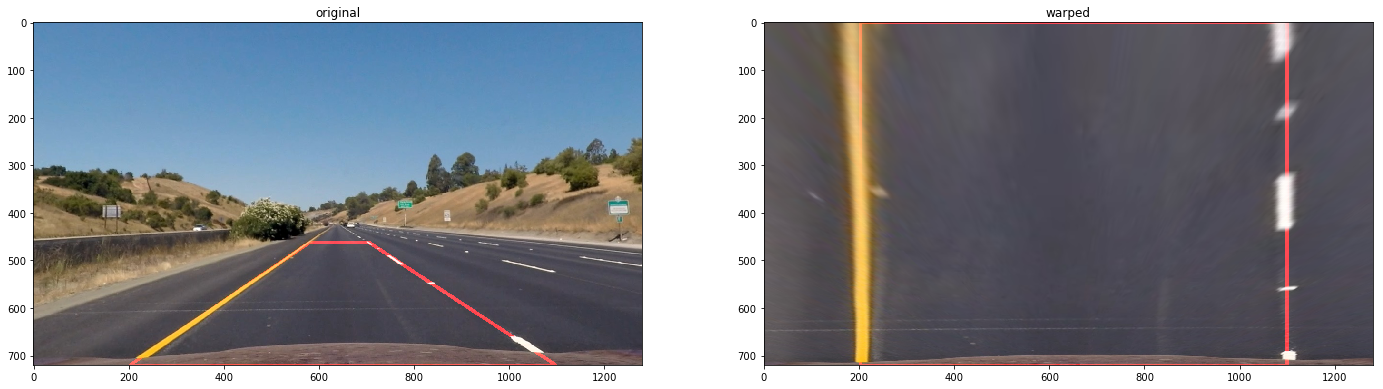

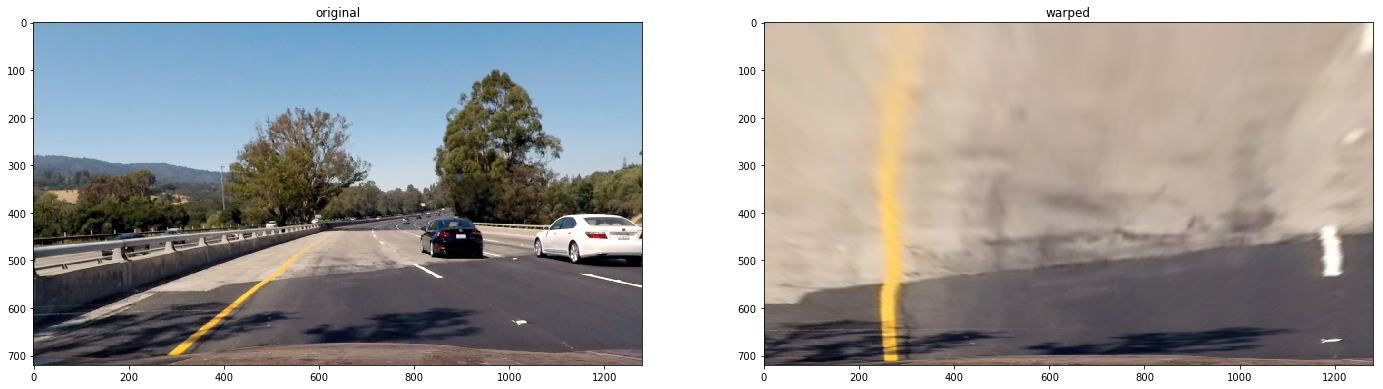

In [38]:
## Setup and test perspective transform.

# Load image of straight lane lines and apply undistortion.
img_straight_bgr = cv2.imread('test_images/straight_lines1.jpg')
img_straight_bgr = cv2.undistort(img_straight_bgr,cameraMatrix,distCoeffs)
img_straight_rgb = cv2.cvtColor(img_straight_bgr,cv2.COLOR_BGR2RGB)


# Points seleted by manual inspetion.
src_points = [(203,720),(1099,720),(707,463),(580,463)]
dst_points = [(203,720),(1099,720),(1099,0),(203,0)]


# Find and apply perspective transform.
M,Minv = get_persprective_transforms(src_points,dst_points)
img_straight_rgb_warped = warp(img_straight_rgb,M)

# Test on train image
plot_many([add_polygon(img_straight_rgb,src_points),add_polygon(img_straight_rgb_warped,dst_points)],
          ['original','warped'],
          [1,2])

# Test on curved lane image
curved_image = cv2.cvtColor(cv2.imread('test_images/test4.jpg'),cv2.COLOR_BGR2RGB)
curved_image = cv2.undistort(curved_image,cameraMatrix,distCoeffs)
transformed_image = warp(curved_image,M)
plot_many([curved_image,transformed_image],['original','warped'],[1,2])
